In [2]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob


## preparing training data
only one day...

In [2]:
!wget -q -r -nH -np --cut-dirs=2 http://people.phys.ethz.ch/~ast/cosmo/bgs_example_data/

In [3]:
!mkdir -p bgs_example_data/seek_cache

In [5]:
!seek --file-prefix='./bgs_example_data' --post-processing-prefix='bgs_example_data/seek_cache' --chi-1=20 --overwrite=True seek.config.process_survey_fft

== Ivy run took:  57.897 s ===
Traversing file system        :   0.006s
Generate gain files           :   0.006s
Initialize                    :   0.000s
Load data                     :  14.805s
Convert TOD                   :   0.048s
Process coordinates           :   0.412s
Masking objects               :   0.671s
Masking artefacts             :   0.002s
Remove RFI                    :   9.661s
postprocessing TOD            :   0.045s
remove background baseline    :   0.524s
Restructure TOD               :   0.572s
ParallelPluginCollection      :  26.743s
Create maps                   :   1.681s
ParallelPluginCollection      :   1.760s
Write maps                    :   0.961s


## setting up the unet

In [10]:
from scripts.radio_util import DataProvider
from tf_unet import unet


In [6]:
files = glob.glob('bgs_example_data/seek_cache/*')

In [ ]:
data_provider = DataProvider(600, files)

net = unet.Unet(channels=data_provider.channels, 
                n_class=data_provider.n_class, 
                layers=3, 
                features_root=64,
                add_regularizers=True,
                )


## training the network
only one epoch. For good results many more are neccessary

In [13]:

trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))
path = trainer.train(data_provider, "./unet_trained_bgs_example_data", 
                     training_iters=32, 
                     epochs=1, 
                     dropout=0.5, 
                     display_step=2)



Layers 3, features 64, filter size 3x3, pool size: 2x2
Removing '/Users/jakeret/workspace/tf_unet/prediction'
Removing '/Users/jakeret/workspace/tf_unet/unet_trained_bgs_example_data'
Allocating '/Users/jakeret/workspace/tf_unet/prediction'
Allocating '/Users/jakeret/workspace/tf_unet/unet_trained_bgs_example_data'
Verification error= 55.0%, loss= 1.4197
Start optimization
Iter 0, Minibatch Loss= 1.4153, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 2, Minibatch Loss= 1.4133, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 4, Minibatch Loss= 1.4125, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 6, Minibatch Loss= 1.4117, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 8, Minibatch Loss= 1.4110, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 10, Minibatch Loss= 1.4102, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 12, Minibatch Loss= 1.4094, Training Accuracy= 0.5445, Minibatch error= 45.6%
Iter 14, Minibatch Loss= 1.4086, Training Accura

## running the prediction on the trained unet

In [14]:
data_provider = DataProvider(12000, files)
x_test, y_test = data_provider(1)
prediction = net.predict(path, x_test)

Number of files used: 1
Model restored from file: ./unet_trained_bgs_example_data/model.cpkt


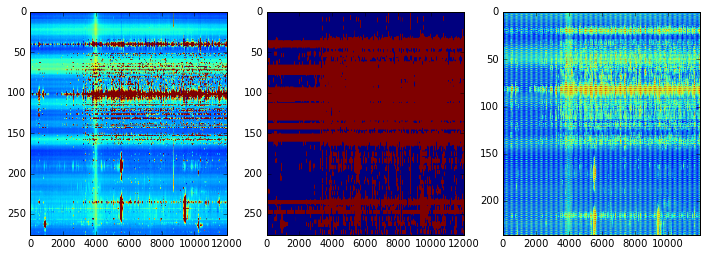

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(prediction[0,...,1], aspect="auto")